#**Physics-based loss and machine learing approach in application to fluids flow modelling: 2D flow domains**

The program recieves an image of the flow domain and the flow rate value, then calculate velocity distribution. The main idea is power loss minimization. The main unknown function is the stream function $\psi = \psi(x_1, x_2)$ that determines the velocity field $\textbf{V} = [[v_1, v_2]]$, where $v_1 = \frac{\partial \psi}{\partial x_2}$, $v_2 = - \frac{\partial \psi}{\partial x_1}$.



#Libraries

## Install libraries

In [266]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## Import libraries

In [267]:
from fastai.vision.all import *
import cv2
from google.colab.patches import cv2_imshow
from collections import OrderedDict

#Functions

## Additional functions

Numerical derivative

In [268]:
def mydiff(j,y,dx):
  '''The function calculates the first order derivative in a specific direction 
     'dx' at a specific point 'j' for a given array 'y' 
     using parabolic approximation
  '''
  dydx = 0
  n = len(y)
  if j==0:
    dydx=(-y[3]+4*y[2]-3*y[1])/(2*dx)
  elif j==n:
    dydx=(3*y[j]-4*y[j-1]+y[j-2])/(2*dx)
  else:
    dydx=(y[j+1]-y[j-1])/(2*dx);
  return (dydx)

Numerical integrals: single and double

In [269]:
def singleIntegral(f,lowerLim,upperLim):
  '''The function calculates the single integral using Simpson's formula. 
     The formula limits are uniform and set from 0 to 1. So, the obtained
     result is multiplied by the difference between the upper and lower limits.
  '''  
  sglInt = 0
  n = len(f)
  x = torch.linspace(0,1,n)
  dxn = x[1]-x[0]

  for i in range (1, (n-1), 2):
    sglInt += (f[i-1] + 4*f[i]+f[i+1])*dxn/3
  if (n % 2) == 0:
    sglInt += (f[-1]+f[-2])*dxn/2

  sglInt = sglInt*(upperLim-lowerLim)

  return (sglInt)

In [270]:
def doublelIntegral(f,lim1,lim2):
  '''The function calculates the double integral using Simpson's formula twice. 
     The formula limits are uniform and set from 0 to 1. So, the obtained
     result is multiplied by the differences between the upper and lower limits.
  '''
  dblInt = 0
  n = f.shape
  x1 = torch.linspace(0,1,n[0])
  x2 = torch.linspace(0,1,n[1])
  dx1n = x1[1]-x1[0]
  dx2n = x2[1]-x2[0]

  for i in range (1, (n[0]-1), 2):
    for j in range (1, (n[1]-1), 2):
      dblInt += (f[i-1][j-1] + f[i+1][j-1] + f[i-1][j+1] + f[i+1][j+1] + 
                   4*(f[i][j+1] + f[i][j-1] + f[i-1][j] + f[i+1][j]) + 
                   16*f[i][j])*dx1n*dx2n/9
          
  dblInt = dblInt*(lim1[1]-lim1[0])*(lim2[1]-lim2[0])

  return (dblInt)

Check double integral 

In [271]:
ss = 101
x = torch.linspace(0,1,ss)
y = torch.linspace(0,1,ss)
y = y.reshape(1,-1).t()
z = (x*x) * (y*y)
print(doublelIntegral(z,[0,1],[0,1]),'- calculated', 1/9, '- exact')

tensor(0.1111) - calculated 0.1111111111111111 - exact


Color filter 

In [272]:
def colorFilter(img, color):
  white = (255,255,255,255)
  black = (0,0,0,255)
  width,heigth = img.size
  for i in range(width):
    for j in range(heigth):
      if img.getpixel((i,j)) == color:
        img.putpixel((i,j),black)
      else:
        #print(img.getpixel((i,j)))
        img.putpixel((i,j),white)
  return (img)

##Major functions

Distributions: the velocity components [[$v_1$, $v_2$]], the strain rate tensor components [[$\xi_{ij}$]], $\xi_{ij}=\xi_{ji}$ . And the shear rate intensity Η. 

In [273]:
def velocityDistr(psi,lim1,lim2):

  n = psi.shape
  v1 = torch.zeros(n)
  v2 = torch.zeros(n)

  x1 = torch.linspace(0,1,n[0])
  x2 = torch.linspace(0,1,n[1])
  dx1n = x1[1]-x1[0]
  dx2n = x2[1]-x2[0]

  for i in range (len(n[0])):
    for j in range (len(n[1])):
      v1[i][j] = - mydiff(i,psi[:,j],dx2n)/lim2[1]
      v2[i][j] = - mydiff(j,psi[i,:],dx1n)/lim1[1]

  return (v1,v2)

In [274]:
def TksiDistr(v1,v2,lim1,lim2):

  n = v1.shape
  xi11 = torch.zeros(n)
  xi12 = torch.zeros(n)
  xi22 = torch.zeros(n)
  Eta = torch.zeros(n)
  Eta2 =torch.zeros(n)

  x1 = torch.linspace(0,1,n[0])
  x2 = torch.linspace(0,1,n[1])
  dx1n = x1[1]-x1[0]
  dx2n = x2[1]-x2[0]

  for i in range (len(n[0])):
    for j in range (len(n[1])):
      xi11[i][j] = mydiff(i,v1[i,:],dx1n)/lim1[1] 
      xi12[i][j] = 0.5*((mydiff(j,v1[:,j],dx2n)/lim2[1])+
                         (mydiff(i,v2[i,:],dx1n)/lim1[1]))
      xi22[i][j] = mydiff(j,v2[:,j],dx2n)/lim2[1]
      #Eta[i][j] = torch.sqrt(2*(xi11[i][j]*xi11[i][j] + 
      #                          2*xi12[i][j]*xi12[i][j] + 
      #                          xi22[i][j]*xi22[i][j]))
      Eta2[i][j] = (2*(xi11[i][j]*xi11[i][j] + 
                                2*xi12[i][j]*xi12[i][j] + 
                                xi22[i][j]*xi22[i][j]))

  return (xi11,xi12,xi22,Eta2)

# Initialization

##Image of the flow domain

Path

In [275]:
 path =  Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss')
 imgPath = path/'ToyDataset'
 imgList = imgPath.ls()
 imgPath.ls()

(#3) [Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates and ball.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates with notch.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates.png')]

##Geometry
The domain of size *'L x L'*  with flow channel is represented as an image of size *'imgSize x imgSize'*. S1 is the upper wall with black label [0 0 0]. S2 and S4 are outlet and inlet surfaces, respectivelly. S3 is the lower wall with blue label [0 0 255]. 

In [276]:
L = 0.1 # L x L flow domain
imgSize = 512 # imgSize x imgSize pixels image
imgNo = 2
upperWallColor =  (0, 0, 0,255)
lowerWallColor =  (0, 0, 255,255)
#Normalized coordinates
x1n = torch.linspace(0,1,imgSize)
x2n = torch.linspace(0,1,imgSize)
lim1 = [0, L]
lim1 = [0, L]

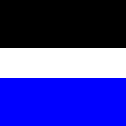

In [277]:
domainMask = Image.open(imgList[imgNo])
domainMask 

Create masks for the walls and resize image

In [278]:
x2n.dtype

torch.float32

In [279]:

upperWallMask = colorFilter(domainMask, upperWallColor)
upperWallMask = upperWallMask.resize((imgSize,imgSize),resample=4)
#upperWallMask

In [280]:
domainMask = Image.open(imgList[imgNo])
lowerWallMask = colorFilter(domainMask, lowerWallColor)
lowerWallMask = lowerWallMask.resize((imgSize,imgSize),resample=4)
#lowerWallMask

##Kinematic properties
The velocity is equal to zero on all the surfaces. The flow rate is known.

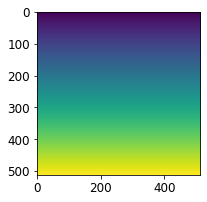

In [281]:
Q = 1 #flow rate through the inlet (outlet) boundary, m^3/s
psim = 0 # lower wall
psip = Q # upper wall
psi00 = torch.linspace(0,1,imgSize, dtype=torch.float32)*torch.ones(imgSize,imgSize)
psi0 = torch.t(psi00)
fig = plt.figure(figsize=(3, 3))
plt.imshow(psi0)

In [282]:
psi00.dtype

torch.float32

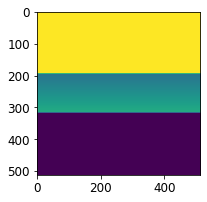

In [283]:
wallsMask = (tensor(upperWallMask)[:,:,1]*tensor(lowerWallMask)[:,:,1])
inverseUpperWallMask = (tensor(upperWallMask)[:,:,1]/(-255)+1)
psi0Masked = (psi0*wallsMask) + (inverseUpperWallMask*Q)
fig = plt.figure(figsize=(3, 3))
plt.imshow(psi0Masked)

In [284]:
#wallsMask[:,1]

In [285]:
#(tensor(upperWallMask)[:,1,1]/(-255)+1)*Q

In [286]:
#psi0Masked[:,1]

##Dynamic properties
The fluid is Newtonian.

In [287]:
mu = 1e-3 # koefficient of dynamic viscosity (viscosity), Pa*s

#Training

##Create model
Unet architecture [2] is used

In [288]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


        
model = UNet(in_channels=1, out_channels=1, init_features=32)

In [289]:
#model

## Optimizer

In [290]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

##Input image

In [291]:
psi0Masked.dtype

torch.float32

In [292]:
#x = torch.randn((1, 1, 512, 512))
x = torch.ones((1, 1, imgSize, imgSize))*psi0Masked
#fig = plt.figure(figsize=(3, 3))
#plt.imshow(x[0,0,:,:])
x.dtype, x.shape

(torch.float32, torch.Size([1, 1, 512, 512]))

In [293]:
model(x)

tensor([[[[0.1824, 0.0076, 0.0684,  ..., 0.1470, 0.1357, 0.2212],
          [0.0106, 0.0242, 0.0557,  ..., 0.0249, 0.1171, 0.1805],
          [0.0041, 0.0019, 0.0017,  ..., 0.0974, 0.5016, 0.2906],
          ...,
          [0.5285, 0.4724, 0.5040,  ..., 0.4863, 0.4089, 0.3423],
          [0.4497, 0.4970, 0.5083,  ..., 0.3895, 0.4219, 0.4020],
          [0.5682, 0.4307, 0.5054,  ..., 0.4828, 0.4720, 0.4574]]]], grad_fn=<SigmoidBackward0>)

In [294]:
history = []

for epoch in range(100):
  psi = model(x)
  v1,v2 = velocityDistr(psi,lim1,lim2)
  xi11,xi12,xi22,Eta2 = TksiDistr(v1,v2,lim1,lim2)
  out = doublelIntegral(0.5*mu*Eta2,lim1,lim2) #loss
  #out = loss(out)
  if out < 1e-6:
      break
  history.append(out.item())
  out.backward()
  optimizer.step()
  print('loss',out)

NameError: ignored

#Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch